In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/DTI_prediction/MolTrans/

/content/drive/MyDrive/DTI_prediction/MolTrans


In [ ]:
%cd MolTrans

/content/drive/MyDrive/DTI_prediction/MolTrans/MolTrans


In [ ]:
# !python train.py --task davis

# **DAVIS data on GCVAE**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

# Load the dataset
file_path = '/content/drive/MyDrive/DTI_prediction/MolTrans/MolTrans/dataset/DAVIS/train.csv'
df = pd.read_csv(file_path)
df = df.sample(n=1000, random_state=42).reset_index(drop=True)
# Assuming the columns are named 'SMILES', 'Target Sequence', and 'Label'
df = df[['SMILES', 'Target Sequence', 'Label']]
print(len(df))

df_val=pd.read_csv('/content/drive/MyDrive/DTI_prediction/MolTrans/MolTrans/dataset/DAVIS/val.csv')
df_val = df_val.sample(n=200, random_state=42).reset_index(drop=True)
# Assuming the columns are named 'SMILES', 'Target Sequence', and 'Label'
df_val = df_val[['SMILES', 'Target Sequence', 'Label']]
print(len(df_val))


df_test=pd.read_csv('/content/drive/MyDrive/DTI_prediction/MolTrans/MolTrans/dataset/DAVIS/test.csv')
df_test = df_test.sample(n=200, random_state=42).reset_index(drop=True)
# Assuming the columns are named 'SMILES', 'Target Sequence', and 'Label'
df_test = df_test[['SMILES', 'Target Sequence', 'Label']]
print(len(df_test))




1000
200
200


In [ ]:

# Tokenization: Extract unique characters from SMILES and protein sequences
smiles_strings = df['SMILES'].tolist()
protein_sequences = df['Target Sequence'].tolist()

smiles_strings_val = df_val['SMILES'].tolist()
protein_sequences_val = df_val['Target Sequence'].tolist()

smiles_strings_test = df_test['SMILES'].tolist()
protein_sequences_test = df_test['Target Sequence'].tolist()




In [ ]:
# Combine all tokens from training, validation, and test sets
all_smiles_tokens = set(''.join(smiles_strings + smiles_strings_val + smiles_strings_test))
all_protein_tokens = set(''.join(protein_sequences + protein_sequences_val + protein_sequences_test))
all_tokens = list(all_smiles_tokens.union(all_protein_tokens))

# Convert tokens to numerical representations
token_to_idx = {token: idx for idx, token in enumerate(all_tokens)}

def tokenize_and_pad(sequences, token_to_idx, max_len):
    token_sequences = [[token_to_idx[token] for token in seq] for seq in sequences]
    padded_sequences = [seq + [0] * (max_len - len(seq)) for seq in token_sequences]
    return torch.tensor(padded_sequences, dtype=torch.long)

# Find max lengths
max_smiles_len = max(max(len(seq) for seq in smiles_strings),
                     max(len(seq) for seq in smiles_strings_val),
                     max(len(seq) for seq in smiles_strings_test))
max_protein_len = max(max(len(seq) for seq in protein_sequences),
                      max(len(seq) for seq in protein_sequences_val),
                      max(len(seq) for seq in protein_sequences_test))

In [ ]:
# Tokenize and pad sequences
smiles_train = tokenize_and_pad(smiles_strings, token_to_idx, max_smiles_len)
protein_train = tokenize_and_pad(protein_sequences, token_to_idx, max_protein_len)
labels_train = torch.tensor(df['Label'].values, dtype=torch.float32).view(-1, 1)

smiles_val = tokenize_and_pad(smiles_strings_val, token_to_idx, max_smiles_len)
protein_val = tokenize_and_pad(protein_sequences_val, token_to_idx, max_protein_len)
labels_val = torch.tensor(df_val['Label'].values, dtype=torch.float32).view(-1, 1)

smiles_test = tokenize_and_pad(smiles_strings_test, token_to_idx, max_smiles_len)
protein_test = tokenize_and_pad(protein_sequences_test, token_to_idx, max_protein_len)
labels_test = torch.tensor(df_test['Label'].values, dtype=torch.float32).view(-1, 1)

In [ ]:
from torch.utils.data import Dataset

class DTI_Dataset(Dataset):
    def __init__(self, smiles, proteins, labels):
        self.smiles = smiles
        self.proteins = proteins
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.smiles[idx], self.proteins[idx], self.labels[idx]


In [ ]:
from torch.utils.data import DataLoader

batch_size = 16

train_dataset = DTI_Dataset(smiles_train, protein_train, labels_train)
val_dataset = DTI_Dataset(smiles_val, protein_val, labels_val)
test_dataset = DTI_Dataset(smiles_test, protein_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the Transformer model for SMILES sequences
class SMILESTransformer(nn.Module):
    def __init__(self, num_tokens, embed_dim, num_heads, num_encoder_layers, dropout=0.5):
        super(SMILESTransformer, self).__init__()
        self.embedding = nn.Embedding(num_tokens, embed_dim)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, batch_first=True),
            num_layers=num_encoder_layers
        )
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, smiles):
        smiles_emb = self.embedding(smiles)  # Transformer with batch_first=True expects input as (batch_size, seq_len, embed_dim)
        smiles_encoded = self.encoder(smiles_emb).mean(dim=1)  # Global average pooling
        return self.fc(smiles_encoded)

In [ ]:
# Define the Transformer model for Protein sequences
class ProteinTransformer(nn.Module):
    def __init__(self, num_tokens, embed_dim, num_heads, num_encoder_layers, dropout=0.5):
        super(ProteinTransformer, self).__init__()
        self.embedding = nn.Embedding(num_tokens, embed_dim)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, batch_first=True),
            num_layers=num_encoder_layers
        )
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, proteins):
        proteins_emb = self.embedding(proteins)  # Transformer with batch_first=True expects input as (batch_size, seq_len, embed_dim)
        proteins_encoded = self.encoder(proteins_emb).mean(dim=1)  # Global average pooling
        return self.fc(proteins_encoded)

In [ ]:
class DTIModel(nn.Module):
    def __init__(self, smiles_transformer, protein_transformer, embed_dim):
        super(DTIModel, self).__init__()
        self.smiles_transformer = smiles_transformer
        self.protein_transformer = protein_transformer
        self.fc = nn.Linear(embed_dim * 2, 1)

    def forward(self, smiles, proteins):
        smiles_out = self.smiles_transformer(smiles)
        proteins_out = self.protein_transformer(proteins)
        combined = torch.cat((smiles_out, proteins_out), dim=1)
        return self.fc(combined)

DTIModel(
  (smiles_transformer): SMILESTransformer(
    (embedding): Embedding(39, 20)
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=20, out_features=20, bias=True)
          )
          (linear1): Linear(in_features=20, out_features=2048, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=2048, out_features=20, bias=True)
          (norm1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
      )
    )
    (fc): Linear(in_features=20, out_features=20, bias=True)
  )
  (protein_transformer): ProteinTransformer(
    (embedding): Embedding(39, 20)
    (encoder): TransformerEncoder(

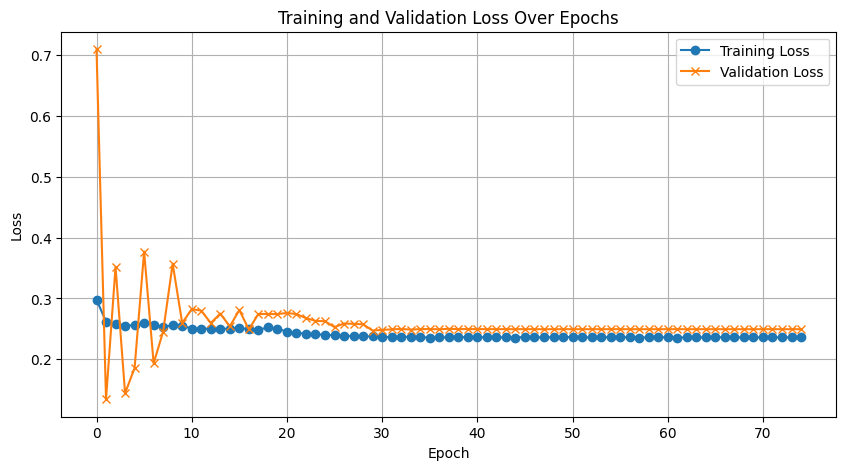

In [ ]:
# Model Initialization
from sklearn.metrics import roc_auc_score, roc_curve
from torch.optim.lr_scheduler import StepLR
num_tokens = len(token_to_idx)
embed_dim = 20
num_heads = 4
num_encoder_layers = 2

smiles_transformer = SMILESTransformer(num_tokens, embed_dim, num_heads, num_encoder_layers)
protein_transformer = ProteinTransformer(num_tokens, embed_dim, num_heads, num_encoder_layers)
dti_model = DTIModel(smiles_transformer, protein_transformer, embed_dim)

# Debugging: Check model parameters
print(dti_model)

# Training loop
optimizer = optim.Adam(dti_model.parameters(), lr=0.01)
criterion = nn.MSELoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

def train_model(model, train_loader, val_loader, epochs=50):
    model.train()
    loss_values = []
    val_loss_values = []

    for epoch in range(epochs):
        total_loss = 0
        for smiles_batch, protein_batch, labels_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(smiles_batch, protein_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for smiles_batch, protein_batch, labels_batch in val_loader:
                val_outputs = model(smiles_batch, protein_batch)
                val_loss = criterion(val_outputs, labels_batch)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_loss_values.append(avg_val_loss)
        scheduler.step()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    return loss_values, val_loss_values

# Run the training
losses, val_losses = train_model(dti_model, train_loader, val_loader, epochs=50)

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(losses,  label='Training Loss')
plt.plot(val_losses,  label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Test AUC: 0.7105


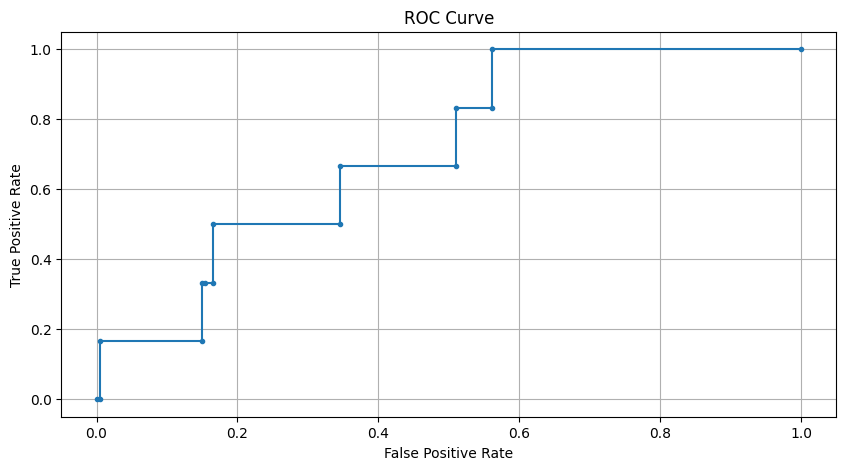

In [ ]:
# Testing loop with AUC and ROC curve
def test_model(model, test_loader):
    model.eval()
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for smiles_batch, protein_batch, labels_batch in test_loader:
            outputs = model(smiles_batch, protein_batch)
            all_outputs.append(outputs)
            all_labels.append(labels_batch)

    all_outputs = torch.cat(all_outputs).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    auc = roc_auc_score(all_labels, all_outputs)
    fpr, tpr, _ = roc_curve(all_labels, all_outputs)

    print(f'Test AUC: {auc:.4f}')

    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

# Run the testing
test_model(dti_model, test_loader)